<a href="https://colab.research.google.com/github/Matheus2608/Data-Science/blob/main/Identificador%20de%20Pragas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Créditos dos dados das pestes das plantações de Tomate
https://data.mendeley.com/datasets/s62zm6djd2/1 ou em https://github.com/Matheus2608/Data-Science/blob/main/Tomato%20pest%20image%20enhancement.7z

Huang , Mei-Ling; Chuang, Tzu Chin (2020), “A database of eight common tomato pest images”, Mendeley Data, V1, doi: 10.17632/s62zm6djd2.1
- Tratam-se de oito pragas em plantações de tomates
- Originalmente essa base dados possuia 609 imagens das pragas, mas com técnicas de augmentation como: 
 - Rotação de 90 graus, 180 graus, 270 graus 
  - Flip horizontal
  - Flip vertical 
  - Cortes


## Bibliotecas necessárias para o modelo da CNN e plotagem de gráficos e imagens

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
!ls

 sample_data  'Tomato pest image enhancement.7z'


## Descompactando o arquivo

In [3]:
!pip install py7zr

     |████████████████████████████████| 76 kB 3.1 MB/s 
     |████████████████████████████████| 2.4 MB 11.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 131 kB 31.8 MB/s 
     |████████████████████████████████| 357 kB 52.3 MB/s 
     |████████████████████████████████| 2.0 MB 33.7 MB/s 


In [4]:
import py7zr
#import brotlicffi as brotli
with py7zr.SevenZipFile("Tomato pest image enhancement.7z", mode='r') as z:
        z.extractall("dataset")

In [5]:
%cd "dataset/"

/content/dataset


## Separando os dados em conjuntos de treinamento e teste

In [6]:
data_dir = 'Tomato pest image enhancement'

In [7]:
img_height,img_width=299, 299
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4263 files belonging to 8 classes.
Using 852 files for validation.


## Exemplos das imagens das pragas com seus respectivas classes em formato de número

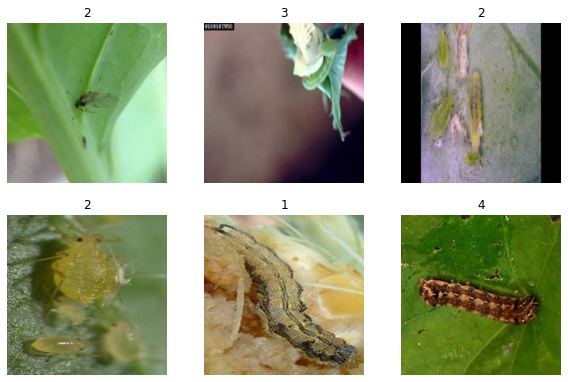

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(int(labels[i])))
    plt.axis("off")

## Transferência de Aprendizagem do Modelo Resnet-50

In [10]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='max',classes=8,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 2s 0us/step


In [11]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(8, activation='softmax'))
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


## Avaliação do modelo usando algumas métricas importantes

In [12]:
from keras import backend as K

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = ['accuracy', recall_metric, precision_metric, f1_metric]

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss=loss, metrics=metrics)
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
107/107 [==============================] - 79s 541ms/step - loss: 4.4953 - accuracy: 0.6371 - recall_metric: 1.2619 - precision_metric: 1.2052 - f1_metric: 1.2312 - val_loss: 0.6367 - val_accuracy: 0.7969 - val_recall_metric: 1.2584 - val_precision_metric: 1.1946 - val_f1_metric: 1.2247
Epoch 2/10
107/107 [==============================] - 54s 504ms/step - loss: 0.3879 - accuracy: 0.8607 - recall_metric: 1.2056 - precision_metric: 1.1285 - f1_metric: 1.1646 - val_loss: 0.4633 - val_accuracy: 0.8415 - val_recall_metric: 1.1858 - val_precision_metric: 1.1284 - val_f1_metric: 1.1554
Epoch 3/10
107/107 [==============================] - 54s 503ms/step - loss: 0.1997 - accuracy: 0.9311 - recall_metric: 1.1212 - precision_metric: 1.0257 - f1_metric: 1.0703 - val_loss: 0.3019 - val_accuracy: 0.8932 - val_recall_metric: 1.1490 - val_precision_metric: 1.0728 - val_f1_metric: 1.1087
Epoch 4/10
107/107 [==============================] - 54s 502ms/step - loss: 0.0949 - accuracy: 0.9710 

In [14]:
history.history.keys() 

dict_keys(['loss', 'accuracy', 'recall_metric', 'precision_metric', 'f1_metric', 'val_loss', 'val_accuracy', 'val_recall_metric', 'val_precision_metric', 'val_f1_metric'])

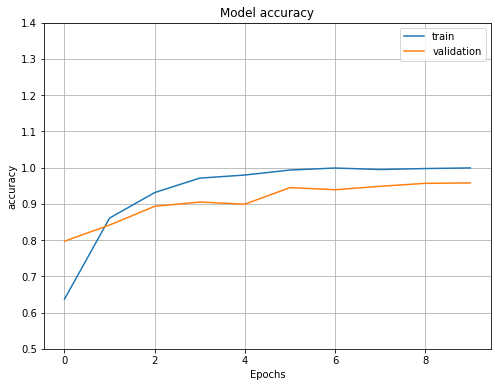

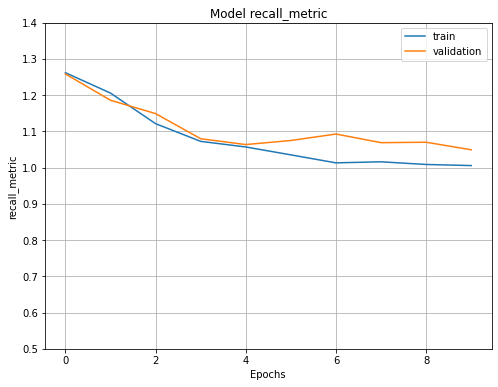

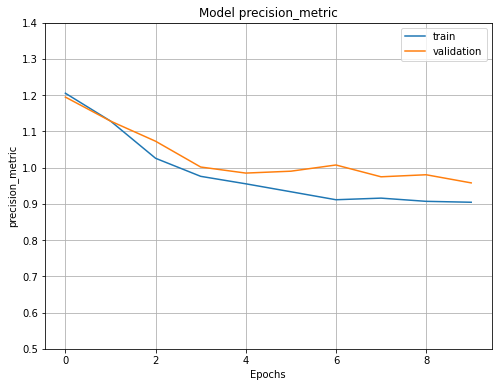

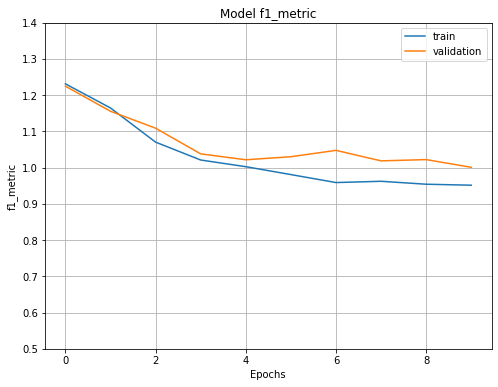

In [15]:
def grafico_metrica(metrica, metrica_validacao):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history[metrica])
  plt.plot(history.history[metrica_validacao])
  plt.axis(ymin=0.5,ymax=1.4)
  plt.grid()
  plt.title(f"Model {metrica}")
  plt.ylabel(metrica)
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])
  plt.show()

grafico_metrica('accuracy', 'val_accuracy')
grafico_metrica('recall_metric', 'val_recall_metric')
grafico_metrica('precision_metric', 'val_precision_metric')
grafico_metrica('f1_metric', 'val_f1_metric')


# Observação:
#### Por meio das métricas, observa-se que o modelo faz predições bem satisfatórias tanto no conjunto de treinamento tanto no conjunto de teste/validação e não está sobreajustado. Portanto, trata-se de um bom modelo para predizere as pragas destas plantações.
#### Porém também é necessário visualizar se ela está tendo um desempenho ruim para alguma das classes de pragas

In [16]:
train_ds, val_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [17]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
class_names = train_ds.class_names
print(class_names)

classes = {key: [] for key in class_names} #primeira lista eh das labels e a outra da predicao
print(classes)

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']
{'BA': [], 'HA': [], 'MP': [], 'SE': [], 'SL': [], 'TP': [], 'TU': [], 'ZC': []}


In [19]:
for images, labels in val_ds:
  for i in range(len(labels)): #numero de batches
    label = int(labels[i])
    classe = class_names[label]
    image = np.expand_dims(images[i],axis=0)
    pred = resnet_model.predict(image)
    output_class = class_names.index(class_names[np.argmax(pred)])
    classes[classe].append(output_class)
  #   print(classe)
  #   print(str(label))
  #   print(output_class)
  # break

In [20]:
soma = 0
for images, labels in val_ds:
  soma += len(labels)
soma

852

In [21]:
soma = 0
for key in classes.keys():
  soma += len(classes[key])
soma

852

In [22]:
i = 0
for key in classes.keys():
  classes[key] = classes[key], [i] * len(classes[key])
  i += 1

In [23]:
len(classes['BA'][0]), classes['BA'][1].count(0)

(77, 77)

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

for key in classes.keys():
  y_true, y_pred = classes[key][1] ,classes[key][0]
  accuracy = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred, average=None)
  precision = precision_score(y_true, y_pred, average=None)
  f1 = f1_score(y_true, y_pred, average=None)
  print(f'Classe {key}')
  print(f'Accuracy: {accuracy}')
  print(f'Recall: {max(recall)}') # para se livrar dos zeros
  print(f'Presicion: {max(precision)}')
  print(f'F1: {max(f1)}')
  print("----------------------------------------")


Classe BA
Accuracy: 0.974025974025974
Recall: 0.974025974025974
Presicion: 1.0
F1: 0.9868421052631579
----------------------------------------
Classe HA
Accuracy: 0.9133333333333333
Recall: 0.9133333333333333
Presicion: 1.0
F1: 0.9547038327526133
----------------------------------------
Classe MP
Accuracy: 0.9834254143646409
Recall: 0.9834254143646409
Presicion: 1.0
F1: 0.9916434540389973
----------------------------------------
Classe SE
Accuracy: 0.9047619047619048
Recall: 0.9047619047619048
Presicion: 1.0
F1: 0.9500000000000001
----------------------------------------
Classe SL
Accuracy: 0.9538461538461539
Recall: 0.9538461538461539
Presicion: 1.0
F1: 0.9763779527559054
----------------------------------------
Classe TP
Accuracy: 1.0
Recall: 1.0
Presicion: 1.0
F1: 1.0
----------------------------------------
Classe TU
Accuracy: 0.9915254237288136
Recall: 0.9915254237288136
Presicion: 1.0
F1: 0.9957446808510638
----------------------------------------
Classe ZC
Accuracy: 0.9827586206

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

#### Pela análise das métricas, a predição não está variando muito favorecendo apenas algum grupo e estão quase excelentes(perto do erro de Bayes). Porém se quiser mais perfeição na predição, é observável que as classes SE e HA possuem um pouco menos de excelência na predição. E o que pode ser feito uma regularização na loss-function quando os labels forem dessas classes, penalizando e ajustando para evitar o sobreajuste nessas classes.

O código abaixo retorna true se a predição da imagem foi correta, falso caso contrário.

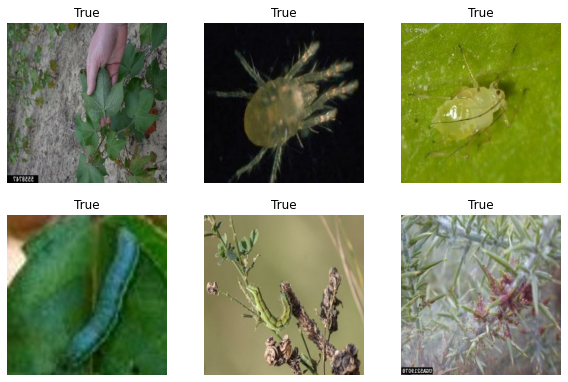

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    label = int(labels[i])
    image = np.expand_dims(images[i],axis=0)
    pred = resnet_model.predict(image)
    output_class = class_names.index(class_names[np.argmax(pred)])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label == output_class)
    plt.axis("off")